In [ ]:

!pip install kaggle

In [ ]:
#upload the credentials of the kaggle account
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sandeepvy","key":"3d4c4bd83760764c26e7a3b39022c523"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:

!kaggle competitions download -c galaxy-zoo-the-galaxy-challenge

  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 38.6MB/s]
 98% 0.99G/1.01G [00:09<00:00, 103MB/s]
100% 1.01G/1.01G [00:09<00:00, 112MB/s]
  0% 0.00/265k [00:00<?, ?B/s]
100% 265k/265k [00:00<00:00, 71.8MB/s]
100% 790M/792M [00:08<00:00, 104MB/s] 
100% 792M/792M [00:08<00:00, 99.1MB/s]
100% 4.63M/4.63M [00:00<00:00, 40.1MB/s]

  0% 0.00/520k [00:00<?, ?B/s]
100% 520k/520k [00:00<00:00, 168MB/s]


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random, shutil
import tensorflow as tf
import seaborn
from tensorflow import keras
from tensorflow.keras import preprocessing, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import image

In [ ]:
!unzip /content/images_training_rev1.zip

In [ ]:
#Set the base paths
base_path = '/content/galaxy-zoo/'
training_solutions = os.path.join(base_path, 'training_solutions_rev1.zip')
training_images    = os.path.join(base_path, 'images_training_rev1')

In [ ]:
df = pd.read_csv(training_solutions, compression="zip")
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new
df.head()

,GalaxyID,Q1.1,Q1.2,Q1.3,Q2.1,Q2.2,Q3.1,Q3.2,Q4.1,Q4.2,Q5.1,Q5.2,Q5.3,Q5.4,Q6.1,Q6.2,Q7.1,Q7.2,Q7.3,Q8.1,Q8.2,Q8.3,Q8.4,Q8.5,Q8.6,Q8.7,Q9.1,Q9.2,Q9.3,Q10.1,Q10.2,Q10.3,Q11.1,Q11.2,Q11.3,Q11.4,Q11.5,Q11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,0.104752,0.512101,0.000000,0.054453,0.945547,0.201463,0.181684,0.000000,0.0,0.027226,0.000000,0.027226,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,0.236781,0.160941,0.234877,0.189149,0.810851,0.000000,0.135082,0.191919,0.0,0.000000,0.140353,0.000000,0.048796,0.000000,0.0,0.012414,0.0,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,0.117790,0.059562,0.000000,0.000000,1.000000,0.000000,0.741864,0.023853,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,0.000000,0.113284,0.125280,0.320398,0.679602,0.408599,0.284778,0.000000,0.0,0.000000,0.096119,0.096119,0.000000,0.128159,0.0,0.000000,0.0,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.029383,0.970617,0.494587,0.439252,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.029383,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [ ]:
ellipticals = df[(df['Q1.1']>0.7) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()

lenticulars = df[(df['Q1.1']>0.7) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()

spirals = df[(df['Q1.2']>0.7) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()

print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))

Total number of elliptical examples:  7311
Total number of lenticular examples:  6625
Total number of spiral examples:  4635


In [ ]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:idx+300]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')
    
    

In [ ]:
my_data="/content/galaxy-zoo-clean/data/"

In [ ]:
_proc_images(training_images, '/content/galaxy-zoo-clean/data/', 'elliptical', ellipticals, 0.40)
_proc_images(training_images,'/content/galaxy-zoo-clean/data/', 'lenticular', lenticulars, 0.40)
_proc_images(training_images, '/content/galaxy-zoo-clean/data/', 'spiral', spirals, 0.40)


elliptical done!
lenticular done!
spiral done!


In [ ]:
print('Total train Elliptical:', len(os.listdir(os.path.join(my_data, 'train', 'elliptical'))))
print('Total train lenticular:', len(os.listdir(os.path.join(my_data, 'train', 'lenticular'))))
print('Total train spiral:', len(os.listdir(os.path.join(my_data, 'train', 'spiral'))))


print('Total validation elliptical:', len(os.listdir(os.path.join(my_data, 'validation', 'elliptical'))))
print('Total validation lenticular:', len(os.listdir(os.path.join(my_data, 'validation', 'lenticular'))))
print('Total validation spiral:', len(os.listdir(os.path.join(my_data, 'validation', 'spiral'))))

Total train Elliptical: 2924
Total train lenticular: 2650
Total train spiral: 1854
Total validation elliptical: 300
Total validation lenticular: 300
Total validation spiral: 300


ELLIPTICAL


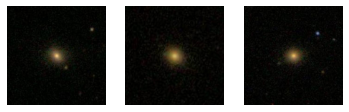

In [ ]:
for num, file in enumerate(os.listdir('/content/galaxy-zoo-clean/data/train/elliptical')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'elliptical', file) , target_size=(227, 227))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)
print("ELLIPTICAL")

LENTICULAR


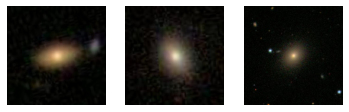

In [ ]:
for num, file in enumerate(os.listdir('/content/galaxy-zoo-clean/data/train/lenticular')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'lenticular', file) , target_size=(227, 227))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)
print("LENTICULAR")

SPIRAL


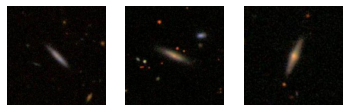

In [ ]:
for num, file in enumerate(os.listdir('/content/galaxy-zoo-clean/data/train/spiral')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'spiral', file) , target_size=(227, 227))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)
print("SPIRAL")

In [ ]:
train_dir = '/content/galaxy-zoo-clean/data/train'
validation_dir = '/content/galaxy-zoo-clean/data/validation'

In [ ]:
total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Total train: 7428
Total validation: 900


In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    )
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(227,227),
                                                    batch_size=128,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(227,227),
                                                         batch_size=64,
                                                         shuffle=True,
                                                         class_mode='categorical')


Found 7428 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
image_shape=(227,227,3)


In [ ]:

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), activation='relu', strides=(4,4), padding='valid', input_shape=image_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), activation='relu', strides=(1,1), padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='valid'),

    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), activation='relu', strides=(1,1), padding='valid'),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', strides=(1,1), padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    # flatten the image pixels
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4096, input_shape=(227*227*3,), activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # 1000 neuron fully connected hidden layer
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 23, 23, 256)       614656    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 9, 384)         885120    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 5, 5, 256)        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_generator, batch_size=128, epochs=30, validation_data=validation_generator, verbose=1)

Epoch 1/30
233/233 [==============================] - 576s 2s/step - loss: 0.8879 - accuracy: 0.5090 - val_loss: 0.6135 - val_accuracy: 0.6900
Epoch 2/30
233/233 [==============================] - 578s 2s/step - loss: 0.6144 - accuracy: 0.6772 - val_loss: 0.5295 - val_accuracy: 0.7433
Epoch 3/30
233/233 [==============================] - 578s 2s/step - loss: 0.5566 - accuracy: 0.7200 - val_loss: 0.4300 - val_accuracy: 0.8178
Epoch 4/30
233/233 [==============================] - 580s 2s/step - loss: 0.4926 - accuracy: 0.7741 - val_loss: 0.3944 - val_accuracy: 0.8222
Epoch 5/30
233/233 [==============================] - 576s 2s/step - loss: 0.4110 - accuracy: 0.8223 - val_loss: 0.3628 - val_accuracy: 0.8389
Epoch 6/30
233/233 [==============================] - 579s 2s/step - loss: 0.3846 - accuracy: 0.8378 - val_loss: 0.3672 - val_accuracy: 0.8578
Epoch 7/30
233/233 [==============================] - 584s 3s/step - loss: 0.3627 - accuracy: 0.8483 - val_loss: 0.4421 - val_accuracy: 0.8122

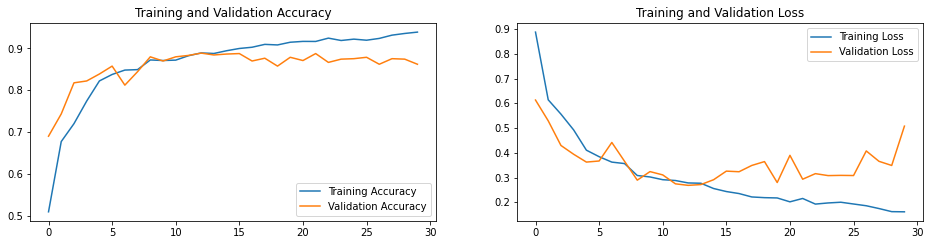

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
model.save_weights('ourmodel.h5')